# Example to load and evaluate fast calorimeter simulation dataset

By Q.LIU.(qibin.liu@cern.ch) Based on [official repo](https://calochallenge.github.io)

# Background
Calorimeter is one of the important detector in high energy physics experiment. As the name noted, this kind of instrument is used to measure the energy of particle, by monitoring the heat, flash light, discharge or other output between energitic particle and calorimeter active material.

This kind of detector is also widely used in medical science, e.g. the main and largest part of CT and PET is some kind of calorimeter in order to measure the x-ray or other particle and to identify medical observation.

The calorimeter of collider experiment looks like (from CERN)

![](https://mediaarchive.cern.ch/MediaArchive/Photo/Public/2008/0803015/0803015_01/0803015_01-A5-at-72-dpi.jpg)

And the one used in PET (from wiki)

![](https://upload.wikimedia.org/wikipedia/commons/f/fc/PET-detectorsystem_2.png)

The calorimeter data should be compared with simulation in order to study the real physics and identified the underlaying process. In that sense almost all the collider study need to generate or simulate the particle interaction with calorimeter, not only in the R&D of this detector but also in the period of data taking and data analysis.

Triditional way to simulate this process involves the "showering", one particle could split into thousands of thousands secondary particles when they fly in the calorimeter and hit material. The compution is huge since it is "Markov Chain Monte Carlo" process and could not be well paralleled. like the plot (from Sven Menke@MPP)

![](https://www.mppmu.mpg.de/~menke/elss/gifs/fe24elwhite_small.gif)

Fast calo sim project aim to design generative machine learning method to directly sampled the output of calorimeter, based on the incident particle, and bypass the hugh computing effort. It could save more than millions of core-hours and euros if finally applied, e.g. in ATLAS experiment.


# Prepare Dataset

The datasets could be found in [official](https://calochallenge.github.io/homepage/) websites. Here we focus on the dataset-2 which is the medium complexity and representive enough.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/Qibin/Internship'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Qibin/Internship


In [ ]:
dataset_train = 'CaloChallenge/Datasets/dataset_2_1.hdf5'
dataset_eval = 'CaloChallenge/Datasets/dataset_2_2.hdf5'


# Inspect the dataset and Understand the structure

In [ ]:
!pip install jetnet

In [ ]:
import h5py as h5
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib as mpl


In [ ]:
# load data
f=h5.File(dataset_train)
print(f['incident_energies'].shape) # condition
print(f['showers'].shape) # data to begenerated

(100000, 1)
(100000, 6480)


In [ ]:
# change the shape to be more interpretable
data=np.reshape(f['showers'][:1000],(-1,45,16,9))
# resulted in 3D cylinder structure: 45 layers in depth(Z); 16 segmentation in angular direction (alpha) and 9 segmentation in radical direction (R)
cond=f['incident_energies'][:1000]

Text(0, 0.5, 'NSample')

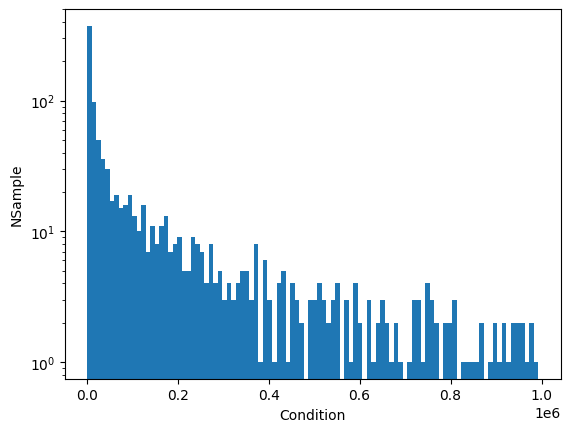

In [ ]:
# investigate the condition
# All the value in the unit of "MeV" and we will hide it
plt.hist(cond,bins=100,log=True)
plt.xlabel("Condition")
plt.ylabel("NSample")

Text(0, 0.5, 'NVoxel in all sample')

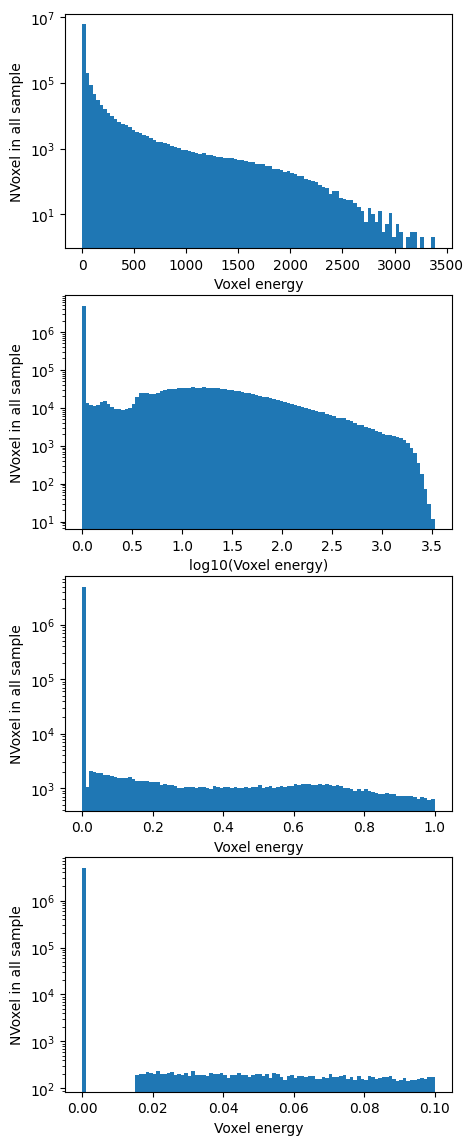

In [ ]:
# investgate the data range
fig,axs=plt.subplots(4,figsize=(5,14))
axs[0].hist(data.flatten(),bins=100,log=True)
axs[0].set_xlabel("Voxel energy")
axs[0].set_ylabel("NVoxel in all sample")
# largest value coul up to 6000, long tail
axs[1].hist(np.log10(1+data.flatten()),bins=100,log=True)
axs[1].set_xlabel("log10(Voxel energy)")
axs[1].set_ylabel("NVoxel in all sample")
# while very sharp peak around 0
axs[2].hist(data.flatten(),range=[0,1],bins=100,log=True)
axs[2].set_xlabel("Voxel energy")
axs[2].set_ylabel("NVoxel in all sample")
axs[3].hist(data.flatten(),range=[0,0.1],bins=100,log=True)
axs[3].set_xlabel("Voxel energy")
axs[3].set_ylabel("NVoxel in all sample")

Text(0, 0.5, 'Cond')

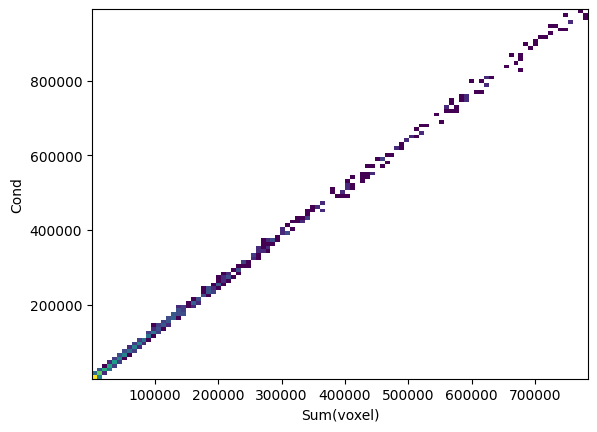

In [ ]:
# One important feature, the sum(voxel) if highly correlated to the condition
plt.hist2d(np.sum(data,axis=(-1,-2,-3)),cond[:,0],bins=100,norm=LogNorm());
plt.xlabel("Sum(voxel)")
plt.ylabel("Cond")

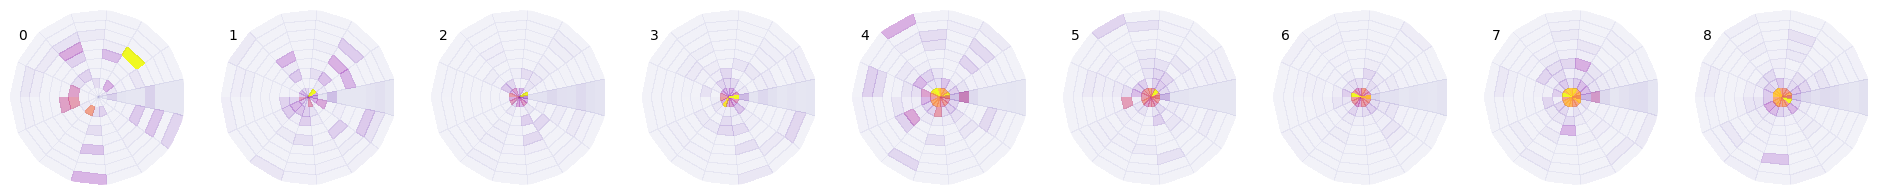

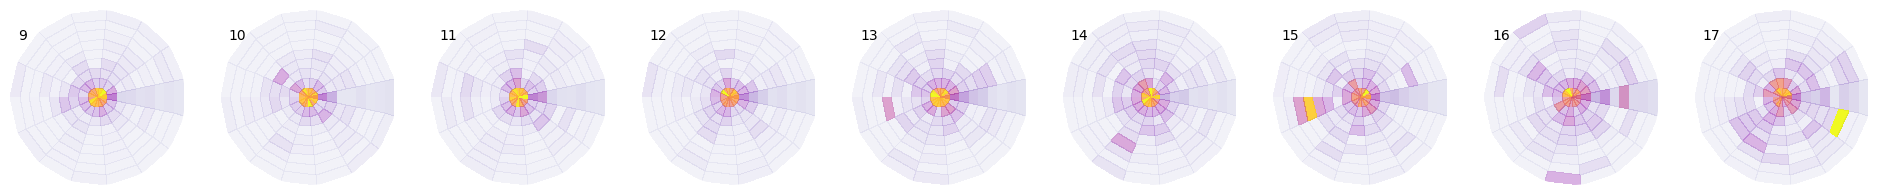

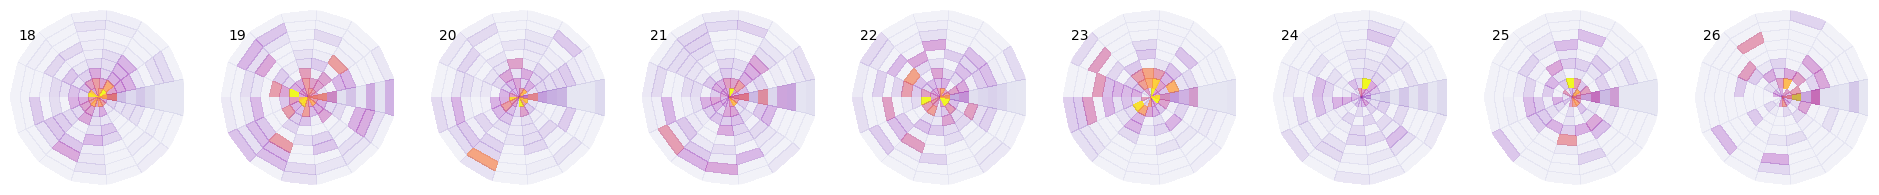

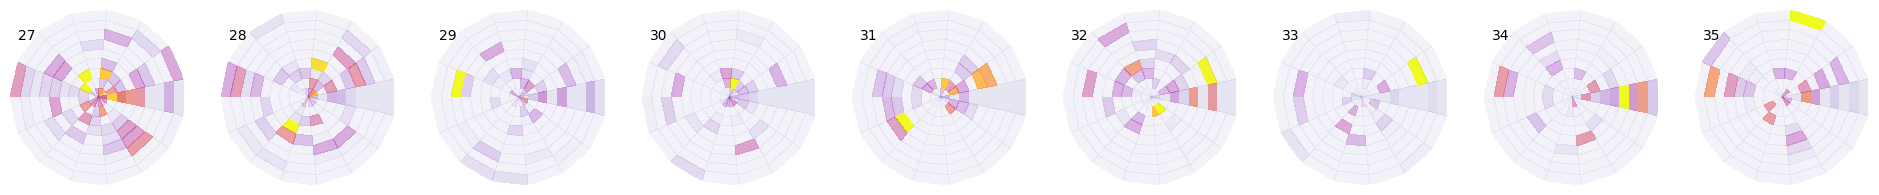

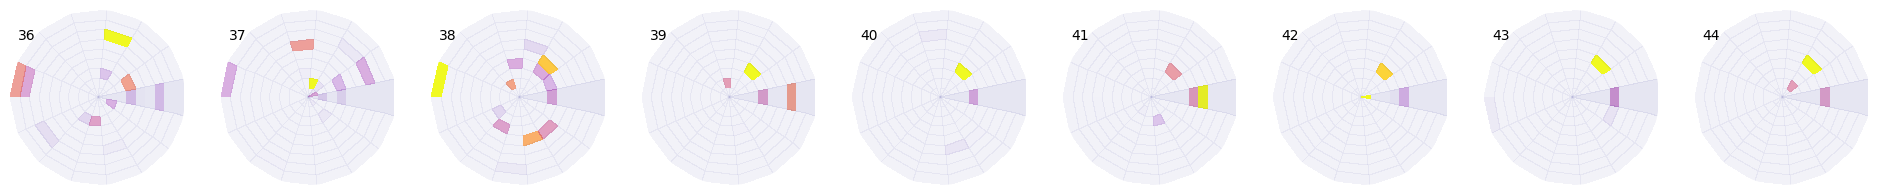

In [ ]:
# one shower could looks like
def bettert_cmap():
    # misc staff to make colormap better
    from matplotlib.colors import ListedColormap
    # Choose colormap which will be mixed with the alpha values
    cmap = plt.cm.afmhot_r

    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))
    # Define the alphas in the range from 0 to 1
    alphas = np.linspace(0, 1, cmap.N)
    # Define the background as white
    BG = np.asarray([1., 1., 1.,])
    # Mix the colors with the background
    for i in range(cmap.N):
        my_cmap[i,:-1] = my_cmap[i,:-1] * alphas[i] + BG * (1.-alphas[i])
    # Create new colormap which mimics the alpha values
    my_cmap = ListedColormap(my_cmap)
    cmap = plt.cm.plasma
    cmap = cmap(np.arange(cmap.N))
    cmap[:, 3] = np.linspace(0.05, 1, 256)
    cmap = ListedColormap(cmap)
    return cmap
def plot_shower(x,ievt=123):
    rad = np.linspace(0, 1, 9)
    ang = np.linspace(0, 2*np.pi, 16)
    r, th = np.meshgrid(rad, ang)

    ncol = 9
    sz = 1.5
    for j in range(5):
        plt.figure(figsize=sz*plt.figaspect(1/ncol))
        for i in range(ncol):
            il = i+j*ncol
            if il >= x.shape[1]: break
            ax = plt.subplot(1, ncol, i+1, projection='polar')
            ax.pcolormesh(th, r, x[ievt,il], shading='auto', cmap=bettert_cmap())
            ax.axis('off');
            ax.text(4*np.pi/5, 1.2, str(il))
plot_shower(data)

Text(0, 0.5, 'NSample')

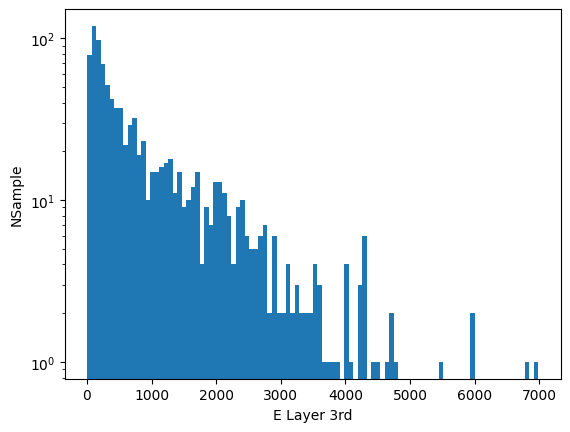

In [ ]:
# One example "physical" variable: energy sum in layer 3rd
Esum3=np.sum(data[:,2,:,:],axis=(-1,-2))
plt.hist(Esum3,bins=100,log=True)
plt.xlabel("E Layer 3rd")
plt.ylabel("NSample")
# we want the generated datat reproduce these physical variable distribution

# Prepare the model and Generate new data

In [ ]:
# design and implement your model.
# .....
# Assuming you have the output of your model called "dataset_gen.hdf5"
# here we dulplicate the training dataset as an ideal testcase
!ln -s dataset_train.hdf5 dataset_gen.hdf5

# Evaluate the quality of "fast simulation"

modified based on [official tool](https://github.com/CaloChallenge/homepage)

## Physics Metric

We evaluete the dataset by using `seperation`, which is the difference between two histograms:

 - one histogram made using truth data
 - the other with generated data

The histogramed variable is usually interesting in physics and the closer two histograms are, the better generated in physics

The detais of the physics variables are listed as below (in total 227 variables, so that 227 metrics)



In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/Qibin/Internship/CaloChallenge/code'

%run evaluate.py \
            --input_file ../Datasets/dataset_2_1.hdf5\
            --reference_file ../Datasets/dataset_2_2.hdf5\
            --mode hist-chi \
            --dataset 2 \
            --output_dir eval_metrics_001

In [ ]:
# read out the seperation value and plot
import pandas as pd
def load_metrics(fn):
    ret={}
    with open(fn) as f:
        m=None
        for l in f:
            l=l.strip()
            if l=="" or "List" in l:
                continue
            l=l.replace(":","")
            if m is None:
                s=l.split(" ")[-1]
                if s.isnumeric():
                    i=int(s)
                    t=" ".join(l.split(" ")[:-1])
                    m=(t,i)
                    if t in ret:
                        ret[t][i]=-1
                    else:
                        ret[t]={i:-1}
                else:
                    i=-1
                    t=l
                    m=(t,i)
                    if t in ret:
                        ret[t][i]=-1
                    else:
                        ret[t]={i:-1}
            else:
                ret[m[0]][m[1]]=float(l)
                m=None
    return pd.DataFrame.from_dict(ret)

# enlarge a little bit the title in plot
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}')
plt.rc('font', family='serif')
params = {
         # 'legend.fontsize': 'x-large',
         # 'figure.figsize': (15, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 20,
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'
}
plt.rcParams.update(params)

def plot_metrics(fn):
    d=load_metrics(fn)
    fig,ax=plt.subplots(1,figsize=(8.5,5.5))
    d[["E layer","EC Eta layer","EC Phi layer","Width Eta layer","Width Phi layer"]].plot(
        logy=True,ax=ax,linestyle='none',markersize=8)
    markers=[
        "*","P","+","p","d",
    ]
    for i, line in enumerate(ax.get_lines()):
        line.set_marker(markers[i])
    ax.set_xlabel("Layer")
    ax.set_ylabel("Sep. Metric")
    ax.set_ylim(1E-4,0.2)
    ax.set_title(f"Performance")
    ax.legend(frameon=False,fontsize = 13)
    plt.show()

### Metrics of each layer (5 metric/layer, 45 layer in total 225 values)
$E(K)$, $\overline{\eta (K)}$, $\overline{\phi (K)}$, $\sigma_{\eta (K)}$, $\sigma_{\phi (K)}$

In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/Qibin/Internship/CaloChallenge/code'

plot_metrics("eval_metrics_001/histogram_chi2_2.txt")

/content/drive/My Drive/Colab Notebooks/Qibin/Internship/CaloChallenge/code


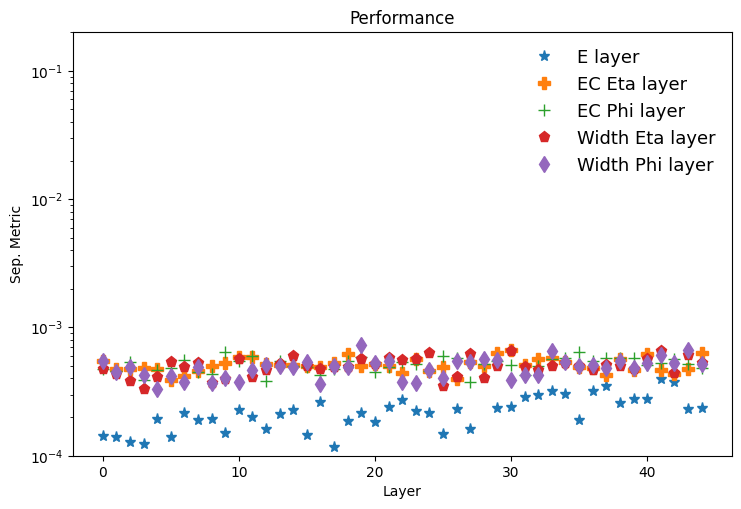

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
fn = "eval_metrics_001/histogram_chi2_2.txt"
d=load_metrics(fn)
fig,ax=plt.subplots(1,figsize=(8.5,5.5))
d[["E layer","EC Eta layer","EC Phi layer","Width Eta layer","Width Phi layer"]].plot(logy=True,ax=ax,linestyle='none',markersize=8)
markers=[
  "*","P","+","p","d",
]
for i, line in enumerate(ax.get_lines()):
  line.set_marker(markers[i])
ax.set_xlabel("Layer")
ax.set_ylabel("Sep. Metric")
ax.set_ylim(1E-4,0.2)
ax.set_title(f"Performance")
ax.legend(frameon=False,fontsize = 13)
plt.show()




```
# This is formatted as code
```

### Total energy metric and voxel energy metric (2 metrics)
$E_{tot}/E_{cond}$, $E_i$

In [ ]:
from IPython.display import Image
Image(filename='eval_metrics_001/E_layer_8_dataset_2.png',width=500,height=500)

FileNotFoundError: [Errno 2] No such file or directory: 'eval_metrics_001/E_layer_8_dataset_2.png'

To be simple, you can take $max(metrics)$ to get the comined metric, which indicates the worst performance of all evaluated physics metric.

The model could reach seperation for all different variables as low as `1E-4` is seens as good

## Classifier Metric

The other metric is called `classifier metric`, which is we train another simplest model to seperate the truth v.s. generated

The lower AUC is, after 50 epoches, the better/higher fidelity the generation is

In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/Qibin/Internship/CaloChallenge/code'

%run evaluate.py \
            --input_file ../Datasets/dataset_2_1.hdf5\
            --reference_file ../Datasets/dataset_2_2.hdf5\
            --mode cls-low \
            --dataset 2 \
            --output_dir eval_metrics_002

[Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/Qibin/Internship/CaloChallenge/code'
/content


Exception: File `'evaluate.py'` not found.

An AUC of as low as `0.7` is seen as good

# End